# Multi-class Logistic Regression & Nerual Networks

This notebook will be splitted into two parts the first part will be OneVSAll Logistic Regression & the second part will be Nerual-Networks implementation.

As usual we will import our handy libraries.

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.image as mpimg

Now let's load our dataset but this time we will loadmat not pandas.read_csv to load our dataset because its on the for of OCTAVE/MatLab no CSV

In [3]:
mat = loadmat("./Data/ex3data1.mat")

X = mat["X"]
y = mat["y"]

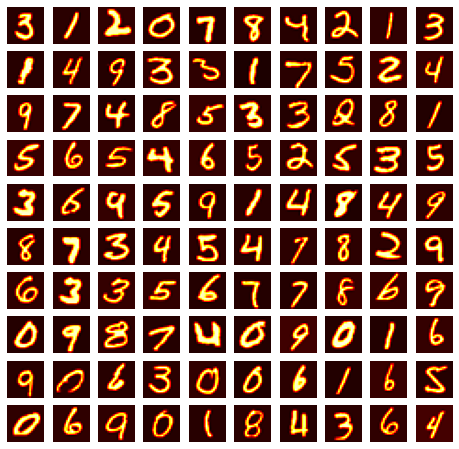

In [4]:
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

### Computing the Sigmoid & Cost Function

Now let's implement our sigmoid function it is the same as the periouvs assignment we could copy past

In [5]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

Let's implement a cost function but, this time we will add the Lambda parameter as the only difference we will add the regularized part<br>
Input: theta -> weights<br>
&emsp; &emsp; &emsp; &ensp;X -> features<br>
&emsp; &emsp; &emsp; &ensp;y -> correct label<br>
&emsp; &emsp; &emsp; &ensp;Lambda -> regularized parameter<br>


Output: gradient<br>
&emsp; &emsp; &emsp;  &emsp; cost of the error

In [23]:
def lrCostFunction(theta, X, y, Lambda):    
    m = len(y)
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

In [24]:
theta_t = np.array([-2, -1, 1, 2]).reshape(4, 1)
X_t = np.array([np.linspace(0.1, 1.5, 15)]).reshape(3, 5).T
X_t = np.hstack((np.ones((5, 1)), X_t))
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, 1)
J, grad = lrCostFunction(theta_t, X_t, y_t, 3)
print("Cost:", J, "Expected cost: 2.534819")
print("Gradients:\n", grad, "\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


Now we will implement the * gradient descent * funcation<br>
Input: X -> features<br>
&emsp; &emsp; &emsp; &ensp;y -> actual value<br>
&emsp; &emsp; &emsp; &ensp;theta -> intial weights<br>
&emsp; &emsp; &emsp; &ensp;alpha -> learning rate<br>
&emsp; &emsp; &emsp; &ensp;num_iters -> number of iteration<br>
&emsp; &emsp; &emsp; &ensp;Lambda -> regularized parameter

Output: theta -> optimized weights<br>
&emsp; &emsp; &emsp; &ensp; J_history -> cost per iteration (later will be used to plot the cost as to make sure our funcation works fine)

In [25]:
def gradientDescent(X, y, theta, alpha, num_iters, Lambda):
    m = len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = lrCostFunction(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history

Since we have more than one class, we will have to train multiple logistic regression classifiers using one-vs-all classification method. Now let's implement one-vs-all method

Input: X -> features<br>
&emsp; &emsp; &emsp; &ensp;y -> actual value<br>
&emsp; &emsp; &emsp; &ensp;num_label -> number of classifiers<br>
&emsp; &emsp; &emsp; &ensp;alpha -> learning rate<br>
&emsp; &emsp; &emsp; &ensp;Lambda -> regularization parameter

Output: matrixOfTheta -> matrix of classifiers<br>

In [26]:
def oneVsAll(X, y, num_labels, Lambda):
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J=[]
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,1,300,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n+1), all_J

Now let's us test what we have done so far by plotting it

In [27]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

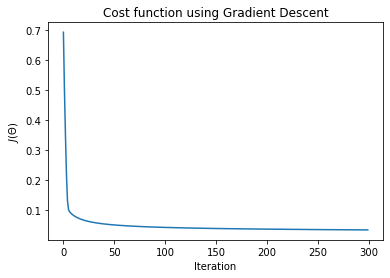

In [28]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

Now if we want to use this model we build of course we will need to build a prediction method

In [29]:
def predictionOneVsAll(all_theta, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m, 1)), X))

    predictions = X @ all_theta.T
    return np.argmax(predictions, axis = 1) + 1

In [31]:
pred = predictionOneVsAll(all_theta, X)
print("Training Set Accuracy:", sum(pred[:, np.newaxis] == y)[0] / 5000*100, "%")

Training Set Accuracy: 91.46 %


# Neural-Network<br>
Now as we finished the * Multi-class Logistic Regression * let's start implement our Neural-Network. first step loading our dataset

In [33]:
mat2 = loadmat("./Data/ex3weights.mat")
Theta1 = mat2["Theta1"] # Theta1 has size 25 x 401
Theta2 = mat2["Theta2"] # Theta2 has size 10 x 26

As we were given the optimized weights * thetas * we will implemnt funcation ** FeedForward ** to use the given weight in prediction
Input: Theata1 -> the first optimized weight<br>
&emsp; &emsp; &emsp; &ensp;Theata1 -> the second optimized<br>
&emsp; &emsp; &emsp; &ensp;X -> vlaues of features<br>


Output: preictionMatriz -> matrix of predicted values<br>

In [34]:
def predict(Theta1, Theat2, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)), X))
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1))
    a2 = sigmoid(a1 @ Theta2.T)

    return np.argmax(a2, axis = 1) + 1

In [35]:
predictions = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(predictions[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 97.52 %


Now let's take a step back and implement everythng from scratch. We will start with our * sigmoid * function

In [36]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1 = grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m * grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

In [37]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

In [38]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost at parameters (non-regularized):",J,"\nCost at parameters (Regularized):",reg_J)

Cost at parameters (non-regularized): 0.28762916516131876 
Cost at parameters (Regularized): 0.3837698590909235


In [40]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [41]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [42]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [43]:
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,0.8,800,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [44]:
pred3 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 94.3 %
